# Inversion of the Caber VTEM max survey for a thin plate target
<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_caber_dataset_verification.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
# !pip install git+https://github.com/JuergHauser/PyP223.git

In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/vtem_max

In [3]:
import numpy
import pandas
import matplotlib.pyplot as plt
import cofi
import json

from forward_lib import (
    ForwardWrapper, 
    problem_setup,
    plot_field_data, 
    plot_transient, 
    plot_predicted_profile, 
    plot_observed_profile,
    get_subset_of_survey, 
    plot_plate_faces, 
    plot_plate_faces_single,
    plot_survey_map
)

numpy.random.seed(42)

## Background

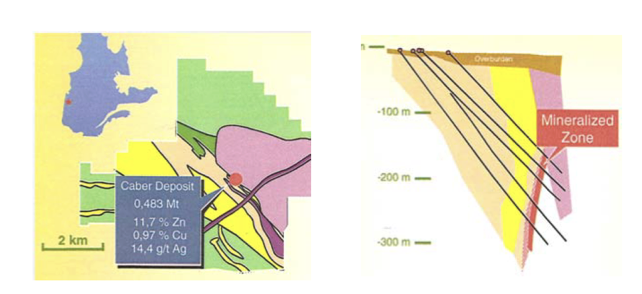

The Caber orebody is a volcanogenic massive sulfide (VMS) deposit in western Quebec, Canada, that hosts significant Zn-Cu-Ag mineralisation and VTEM max surveys have been collected over the target and previously been inverted recovering subvertical body dipping at about 80 degrees to the southwest.


## Further Reading

Prikhodko, A., Morrison, E., Bagrianski, A., Kuzmin, P., Tishin, P., & Legault, J. (2010). Evolution of VTEM? technical solutions for effective exploration. ASEG Extended Abstracts, 2010(1), 1-4.

McMillan, M. S., Schwarzbach, C., Haber, E., & Oldenburg, D. W. (2015). 3D parametric hybrid inversion of time-domain airborne electromagnetic data. Geophysics, 80(6), K25-K36.

In [4]:
# Load the data files 
with open('caber_survey.npy', 'rb') as f:
    survey_setup = numpy.load(f,allow_pickle=True)
    system_spec = numpy.load(f,allow_pickle=True)
    data_obs = numpy.load(f,allow_pickle=True)

In [5]:
survey_setup=survey_setup.tolist()
system_spec=system_spec.tolist()

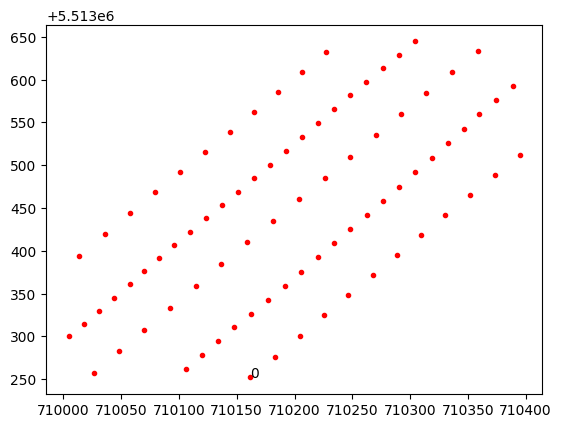

In [6]:
plot_survey_map(survey_setup)

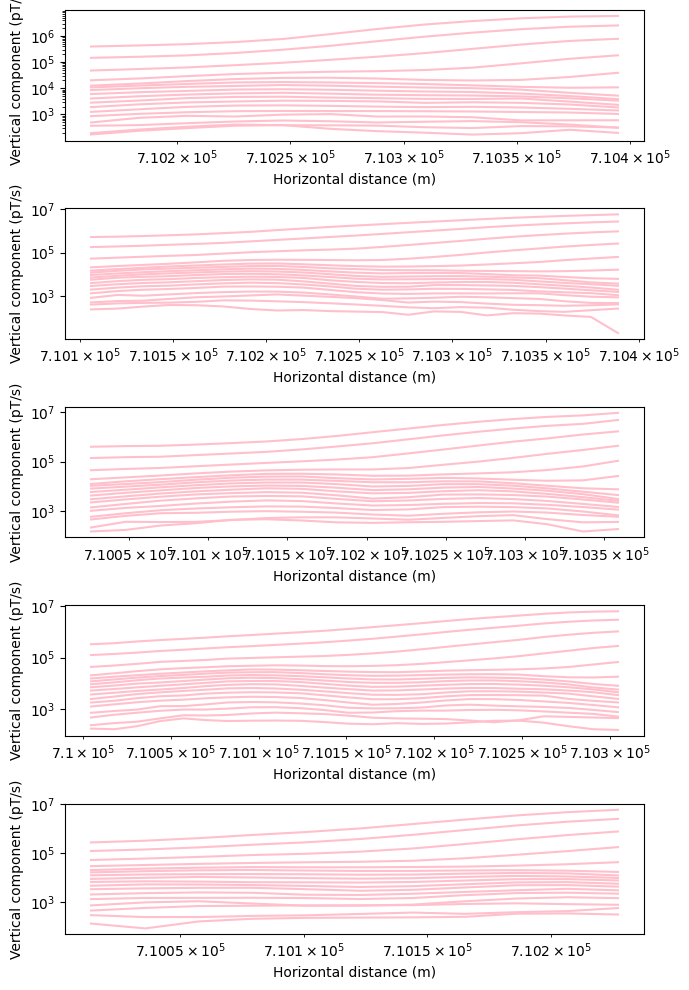

In [7]:
_, axes = plt.subplots(5, 1, figsize=(7, 10))

for i in range(5):
    plot_observed_profile(survey_setup, data_obs, label="observed data", gate_idx=numpy.arange(0, 34, 2), 
                              line_id=[i], ax=axes[i], color="pink")
plt.tight_layout()

In [8]:
# initial guess
initial_model = {
    "res": numpy.array([1000, 1000]), 
    "thk": numpy.array([25]), 
    "peast": numpy.array([710200]), 
    "pnorth": numpy.array([5513450]), 
    "ptop": numpy.array([150]), 
    "pres": numpy.array([0.008]), 
    "plngth1": numpy.array([150]), 
    "plngth2": numpy.array([150]), 
    "pwdth1": numpy.array([0.1]), 
    "pwdth2": numpy.array([500]), 
    "pdzm": numpy.array([225]),
    "pdip": numpy.array([80])
}

In [9]:
problem_setup['cellw']=100

In [10]:
forward = ForwardWrapper(initial_model, problem_setup, system_spec, survey_setup,
                         ["pdip","pdzm", "pwdth2","ptop","plngth1","plngth2"], data_returned=["vertical"])

['pdip', 'pdzm', 'pwdth2', 'ptop', 'plngth1', 'plngth2']


In [11]:
forward.params_to_invert

['pdip', 'pdzm', 'plngth1', 'plngth2', 'ptop', 'pwdth2']

In [12]:
init_param_value=[90,200,150,150,150,500]
init_param_value=[90,180,150,150,150,500]

#### Define helper functions for inversion

In [13]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model)
    residual = dpred - data_obs
    return 2 * jacobian.T @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return 2 * jacobian.T @ jacobian

In [14]:
class CallbackFunction:
    def __init__(self):
        self.x = None
        self.i = 0

    def __call__(self, xk):
        print(f"Iteration #{self.i+1}")
        print(f"  objective value: {my_problem.objective(xk)}")
        self.x = xk
        self.i += 1

**Define CoFI problem**

In [15]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

**Define CoFI options**

In [16]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
#my_options.set_params(method="newton-cg", options={"maxiter": 5}, callback=CallbackFunction())
my_options.set_params(method="trust-ncg", options={"maxiter": 10}, callback=CallbackFunction())

**Define CoFI inversion**

In [17]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

Iteration #1
  objective value: 3682.494718769213
Iteration #2
  objective value: 3652.5047003188697
Iteration #3
  objective value: 3598.261132205339
Iteration #4
  objective value: 3510.558271416468
Iteration #5
  objective value: 3393.8581854681856
Iteration #6
  objective value: 3337.426747155244
Iteration #7
  objective value: 3334.6630691008763
Iteration #8
  objective value: 3334.663070420654
Iteration #9
  objective value: 3334.663073413456
Iteration #10
  objective value: 3334.663070412747
[ 89.08498446 206.93167412 135.42586494 142.55275302 199.5774908
 505.35129288]


In [18]:
my_result.message

'Maximum number of iterations has been exceeded.'

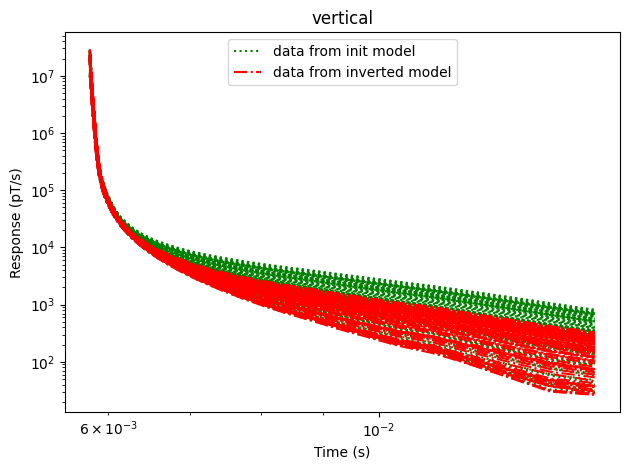

In [19]:
_, ax = plt.subplots()
plot_transient(init_param_value, forward, "data from init model", ax, color="green", linestyle=":")
plot_transient(my_result.model, forward, "data from inverted model", ax, color="red", linestyle="-.")
ax.legend(loc="upper center")
ax.set_title("vertical")
plt.tight_layout()

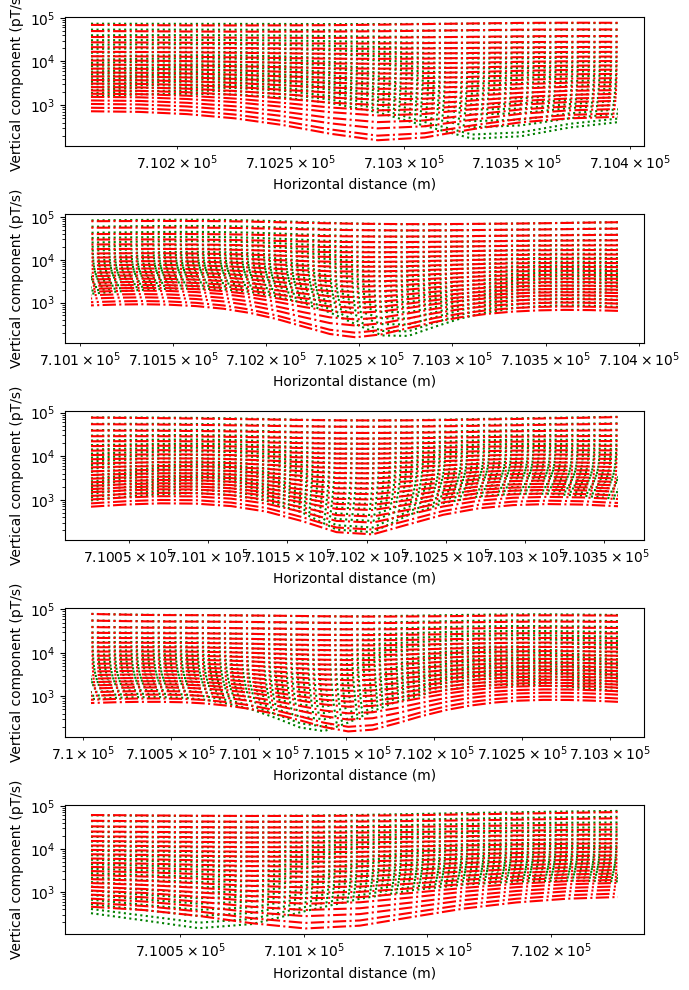

In [20]:
idx_to_plot = numpy.arange(8, 30)       # (0, 44)

_, axes = plt.subplots(5, 1, figsize=(7,10))

for i in range(5):
    plot_predicted_profile(init_param_value, forward, "data from init model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="green", linestyle=":")
    plot_predicted_profile(my_result.model, forward, "data from inverted model", gate_idx=idx_to_plot, 
                                        line_id=[i], ax=axes[i], color="red", linestyle="-.")
ax.legend(loc="upper center")
plt.tight_layout()

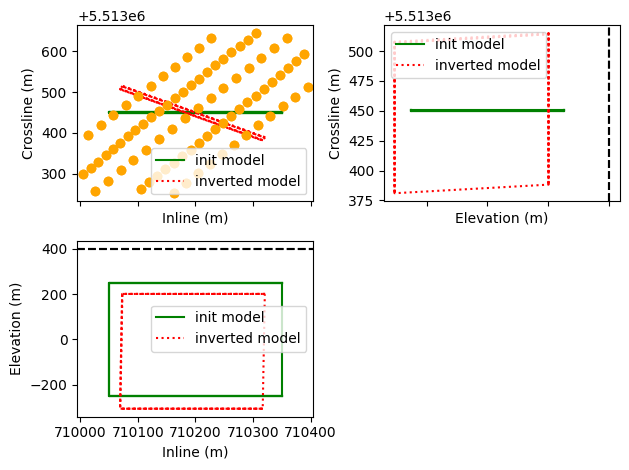

In [21]:
_, axes = plt.subplots(2, 2, sharex="col")
axes[1,1].axis("off")
plot_plate_faces(
    "plate_init", forward, init_param_value, 
    axes[0,0], axes[0,1], axes[1,0], color="green", label="init model"
)
plot_plate_faces(
    "plate_inverted", forward, my_result.model, 
    axes[0,0], axes[0,1], axes[1,0], color="red", label="inverted model", linestyle="dotted"
)
axes[0,0].legend()
axes[0,1].legend()
axes[1,0].legend()
plt.tight_layout()

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [22]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.9
numpy 2.0.1
scipy 1.14.0
matplotlib 3.9.1.post1
